Resumo de liquidez por ativo:


,TckrSymb,TotalQty,TotalVol,MinPrice,MaxPrice,AvgPrice
0,A1AP34,8.0,215.70,19.56,19.56,19.56
1,A1DI34,1.0,684.24,684.24,684.24,684.24
2,A1DM34,2.0,8804.75,340.30,340.30,340.30
3,A1EG34,6.0,4682.12,43.16,43.16,43.16
4,A1ES34,2.0,218.12,73.08,73.08,73.08


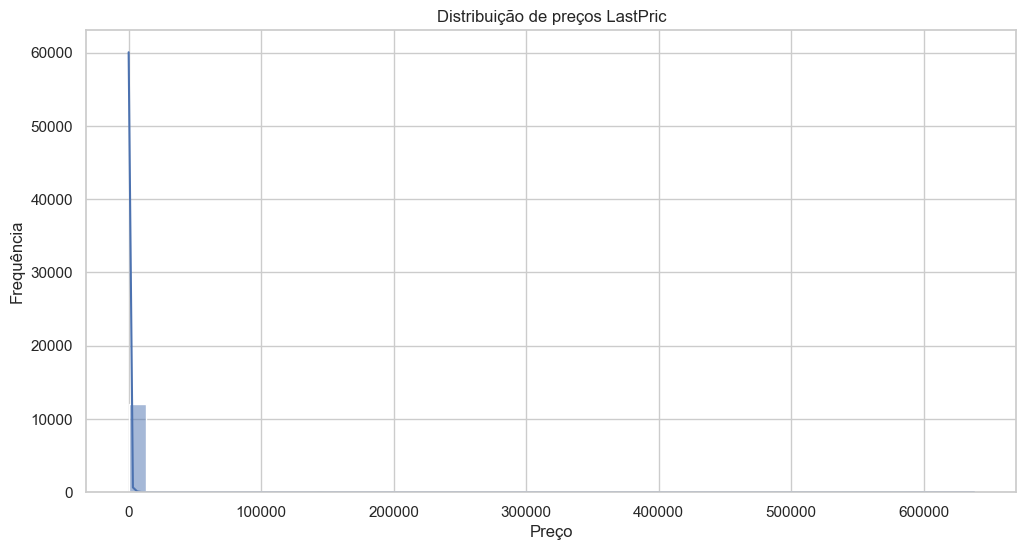

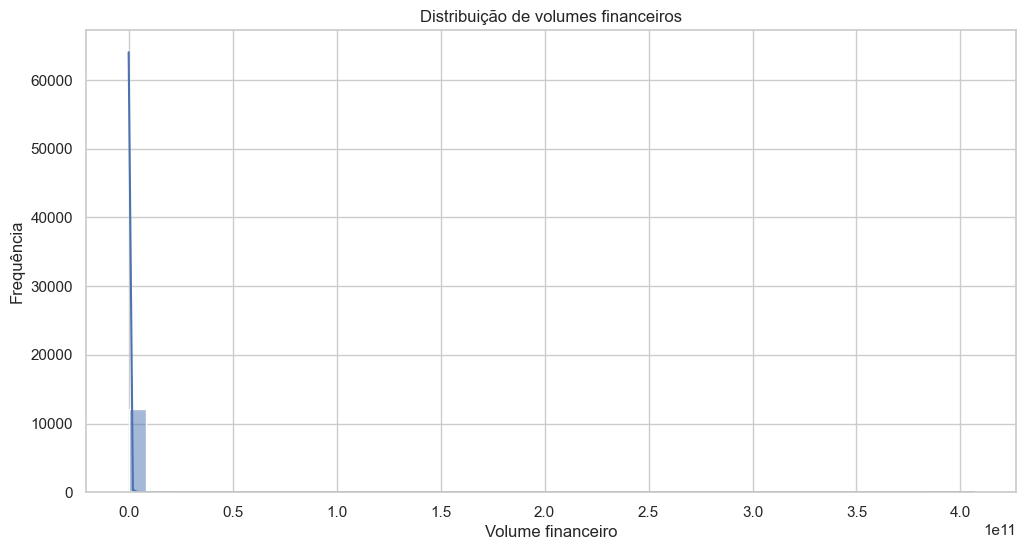

Resumo de volatilidade por ativo:


,TckrSymb,PriceVolatility
0,A1AP34,NaN
1,A1DI34,NaN
2,A1DM34,NaN
3,A1EG34,NaN
4,A1ES34,NaN


C:\Users\Guilherme\AppData\Local\Temp\ipykernel_19804\1606536734.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_liquid, x='TckrSymb', y='TotalVol', palette="viridis")


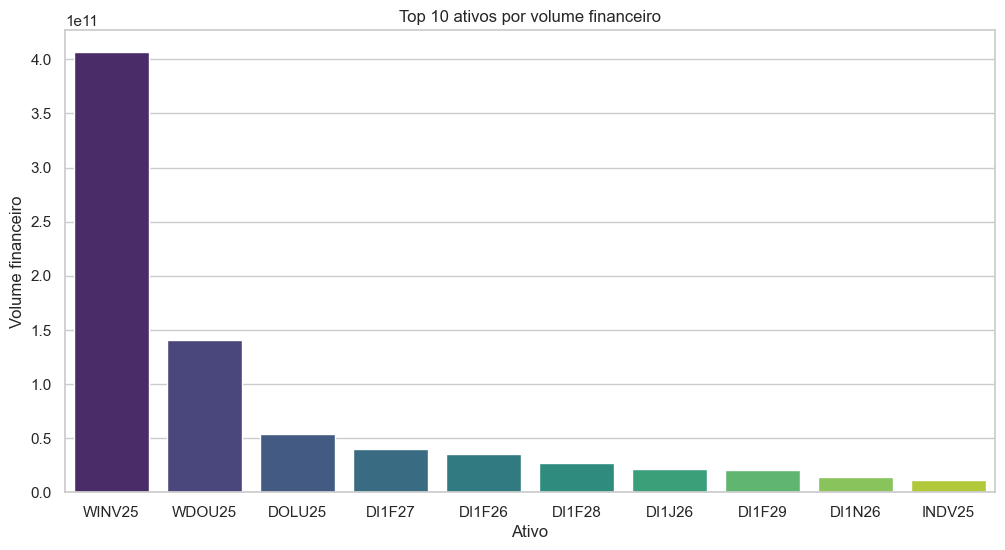

Arquivo processado salvo em: data/processed\merged_liquidity_risk.csv


In [1]:
# 03_liquidity_risk.ipynb
# =====================================
# Cálculo de Métricas de Liquidez e Risco - B3
# =====================================

# ------------------------
# 0. Importar bibliotecas
# ------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações gerais de visualização
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# ------------------------
# 1. Definir diretório e arquivos
# ------------------------
os.chdir(r"D:\Documentos\PROJETOS\Análise de Risco e Liquidez — B3 (Listado)")
RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

instruments_file = os.path.join(RAW_DIR, "InstrumentsConsolidatedFile_20250822_1.csv")
trades_file = os.path.join(RAW_DIR, "TradeInformationConsolidatedFile_20250822_1.csv")

# ------------------------
# 2. Ler CSVs (como string para evitar problemas de encoding)
# ------------------------
df_instruments = pd.read_csv(instruments_file, sep=';', encoding='latin1', skiprows=1, dtype=str)
df_trades = pd.read_csv(trades_file, sep=';', encoding='latin1', skiprows=1, dtype=str)

# ------------------------
# 3. Limpeza de colunas
# ------------------------
df_instruments.columns = df_instruments.columns.str.strip()
df_trades.columns = df_trades.columns.str.strip()

# Converter datas
df_trades['RptDt'] = pd.to_datetime(df_trades['RptDt'], dayfirst=False)
df_instruments['RptDt'] = pd.to_datetime(df_instruments['RptDt'], dayfirst=False)

# ------------------------
# 4. Limpeza e conversão numérica de preços
# ------------------------
price_cols = ['MinPric','MaxPric','TradAvrgPric','LastPric']

for col in price_cols:
    df_trades[col] = df_trades[col].str.replace(',', '.').astype(float)

# ------------------------
# 5. Merge dos dados
# ------------------------
df_merged = df_trades.merge(
    df_instruments,
    how='left',
    left_on='TckrSymb',
    right_on='TckrSymb'
)

# ------------------------
# 6. Métricas de liquidez
# ------------------------
# Volume total negociado por ativo
df_merged['TradQty'] = pd.to_numeric(df_merged['TradQty'].str.replace(',','.'), errors='coerce')
df_merged['NtlFinVol'] = pd.to_numeric(df_merged['NtlFinVol'].str.replace(',','.'), errors='coerce')

liquidity_summary = df_merged.groupby('TckrSymb').agg({
    'TradQty': 'sum',
    'NtlFinVol': 'sum',
    'LastPric': ['min','max','mean']
}).reset_index()
liquidity_summary.columns = ['TckrSymb','TotalQty','TotalVol','MinPrice','MaxPrice','AvgPrice']

print("Resumo de liquidez por ativo:")
display(liquidity_summary.head())

# ------------------------
# 7. Distribuição de preços e volumes
# ------------------------
# Histograma de preços
plt.figure()
sns.histplot(df_merged['LastPric'], bins=50, kde=True)
plt.title("Distribuição de preços LastPric")
plt.xlabel("Preço")
plt.ylabel("Frequência")
plt.show()

# Histograma de volumes
plt.figure()
sns.histplot(df_merged['NtlFinVol'].dropna(), bins=50, kde=True)
plt.title("Distribuição de volumes financeiros")
plt.xlabel("Volume financeiro")
plt.ylabel("Frequência")
plt.show()

# ------------------------
# 8. Métricas de risco simples
# ------------------------
# Volatilidade diária por ativo (std de LastPric)
risk_summary = df_merged.groupby('TckrSymb')['LastPric'].std().reset_index()
risk_summary.columns = ['TckrSymb','PriceVolatility']

print("Resumo de volatilidade por ativo:")
display(risk_summary.head())

# ------------------------
# 9. Top ativos por liquidez
# ------------------------
top_liquid = liquidity_summary.sort_values('TotalVol', ascending=False).head(10)
plt.figure()
sns.barplot(data=top_liquid, x='TckrSymb', y='TotalVol', palette="viridis")
plt.title("Top 10 ativos por volume financeiro")
plt.xlabel("Ativo")
plt.ylabel("Volume financeiro")
plt.show()

# ------------------------
# 10. Salvar CSV processado para Streamlit
# ------------------------
processed_file = os.path.join(PROCESSED_DIR, "merged_liquidity_risk.csv")
df_merged.to_csv(processed_file, sep=';', index=False)
print(f"Arquivo processado salvo em: {processed_file}")
